In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [19]:
model = nn.Sequential(

    # Block 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 32×32 → 16×16

    # Block 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 16×16 → 8×8

    # Block 3
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),      # 8×8 → 4×4

    # Block 4
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Flatten(),

    nn.Linear(256 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 100)   # CIFAR-100
)


In [20]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),      # 32×32 → 16×16

        # Block 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),      # 16×16 → 8×8

        # Block 3
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),      # 8×8 → 4×4

        # Block 4
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Flatten(),

        nn.Linear(256 * 4 * 4, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 100)   # CIFAR-100
    )


In [21]:
def set_seed(seed):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [34]:
def plot_training_curves(results_dict):
    plt.figure(figsize=(12,5))

    # ---- Training Loss ----
    plt.subplot(2,2,1)
    for name, history in results_dict.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results_dict.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # ---- Validation Accuracy ----
    plt.subplot(2,2,3)
    for name, history in results_dict.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results_dict.items():
        plt.plot(history["val_acc"], label=f"{name} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [22]:
# 3. Προετοιμασία συνόλου δεδομένων CIFAR-100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
# 4. Ορισμός συναρτήσεων κόστους και βελτιστοποίησης
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [24]:
# --------------------------------------------------------
# 5. Εκπαίδευση
# --------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = make_model().to(device)

def train_one(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100*correct/total
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} "
          f"| TrainLoss: {train_loss:.4f} "
          f"| ValLoss: {val_loss:.4f} "
          f"| TrainAcc: {train_acc:.2f}% "
          f"| ValAcc: {val_acc:.2f}%")

    return history



In [25]:
def evaluate(model, loader, criterion, device):
    model.eval()
    correct, total = 0,0
    running_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(loader)
    val_acc = 100*correct/total
    return val_loss, val_acc

In [26]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
for lr in lrs:
    print(f"Training with LR={lr}")
    set_seed(0)
    model = make_model()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_one(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)


Training with LR=0.01
Epoch 1/5 | TrainLoss: 4.6903 | ValLoss: 4.6070 | TrainAcc: 0.93% | ValAcc: 1.00%
Epoch 2/5 | TrainLoss: 4.6089 | ValLoss: 4.6071 | TrainAcc: 0.97% | ValAcc: 1.00%
Epoch 3/5 | TrainLoss: 4.6091 | ValLoss: 4.6075 | TrainAcc: 0.92% | ValAcc: 1.00%
Epoch 4/5 | TrainLoss: 4.6092 | ValLoss: 4.6072 | TrainAcc: 0.99% | ValAcc: 1.00%
Epoch 5/5 | TrainLoss: 4.6089 | ValLoss: 4.6073 | TrainAcc: 0.93% | ValAcc: 1.00%
Training with LR=0.001
Epoch 1/5 | TrainLoss: 3.8562 | ValLoss: 3.3021 | TrainAcc: 10.29% | ValAcc: 18.94%
Epoch 2/5 | TrainLoss: 3.2595 | ValLoss: 2.8028 | TrainAcc: 19.08% | ValAcc: 28.26%
Epoch 3/5 | TrainLoss: 2.9269 | ValLoss: 2.5234 | TrainAcc: 25.19% | ValAcc: 33.73%
Epoch 4/5 | TrainLoss: 2.6949 | ValLoss: 2.3773 | TrainAcc: 29.87% | ValAcc: 38.77%


KeyboardInterrupt: 

In [100]:
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
for opt_cls in optimizers:
    print(f"Training with {opt_cls.__name__}")
    set_seed(0)
    model = make_model().to(device)
    optimizer = opt_cls(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_one(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)


Training with Adam
Epoch 1/5, Loss: 3.8562, Val Acc: 18.94%
Epoch 2/5, Loss: 3.2595, Val Acc: 28.26%
Epoch 3/5, Loss: 2.9269, Val Acc: 33.73%
Epoch 4/5, Loss: 2.6949, Val Acc: 38.77%
Epoch 5/5, Loss: 2.5147, Val Acc: 40.52%
Training with SGD
Epoch 1/5, Loss: 4.5429, Val Acc: 4.85%
Epoch 2/5, Loss: 4.3732, Val Acc: 7.94%
Epoch 3/5, Loss: 4.2136, Val Acc: 11.32%
Epoch 4/5, Loss: 4.0762, Val Acc: 13.67%
Epoch 5/5, Loss: 3.9437, Val Acc: 15.66%
Training with RMSprop
Epoch 1/5, Loss: 4.4432, Val Acc: 7.23%
Epoch 2/5, Loss: 4.1149, Val Acc: 10.21%
Epoch 3/5, Loss: 3.8587, Val Acc: 13.74%
Epoch 4/5, Loss: 3.5949, Val Acc: 20.31%
Epoch 5/5, Loss: 3.2931, Val Acc: 24.77%


Training with CrossEntropyLoss()
Epoch 1/5 | TrainLoss: 3.8562 | ValLoss: 3.3021 | TrainAcc: 10.29% | ValAcc: 18.94%
Epoch 2/5 | TrainLoss: 3.2595 | ValLoss: 2.8028 | TrainAcc: 19.08% | ValAcc: 28.26%
Epoch 3/5 | TrainLoss: 2.9269 | ValLoss: 2.5234 | TrainAcc: 25.19% | ValAcc: 33.73%
Epoch 4/5 | TrainLoss: 2.6949 | ValLoss: 2.3773 | TrainAcc: 29.87% | ValAcc: 38.77%
Epoch 5/5 | TrainLoss: 2.5147 | ValLoss: 2.2184 | TrainAcc: 33.46% | ValAcc: 40.52%

--- Αποτελέσματα Loss Functions ---


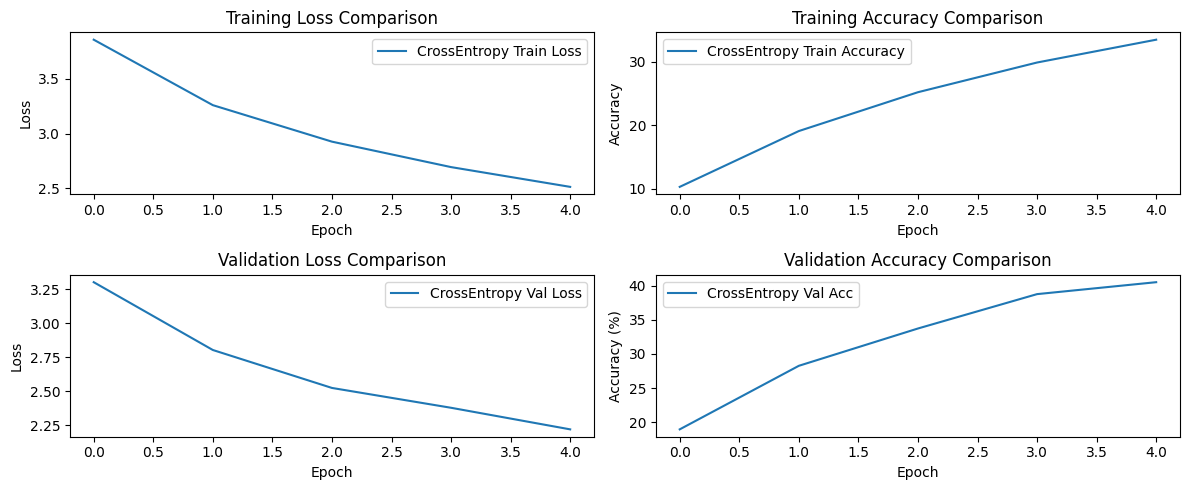

Training with CrossEntropyLoss()
Epoch 1/5 | TrainLoss: 4.0161 | ValLoss: 3.5518 | TrainAcc: 10.55% | ValAcc: 20.46%
Epoch 2/5 | TrainLoss: 3.5513 | ValLoss: 3.2044 | TrainAcc: 19.82% | ValAcc: 28.51%
Epoch 3/5 | TrainLoss: 3.3045 | ValLoss: 3.0156 | TrainAcc: 25.67% | ValAcc: 33.17%
Epoch 4/5 | TrainLoss: 3.1290 | ValLoss: 2.9070 | TrainAcc: 30.26% | ValAcc: 37.56%
Epoch 5/5 | TrainLoss: 2.9908 | ValLoss: 2.6950 | TrainAcc: 34.07% | ValAcc: 43.43%

--- Αποτελέσματα Loss Functions ---


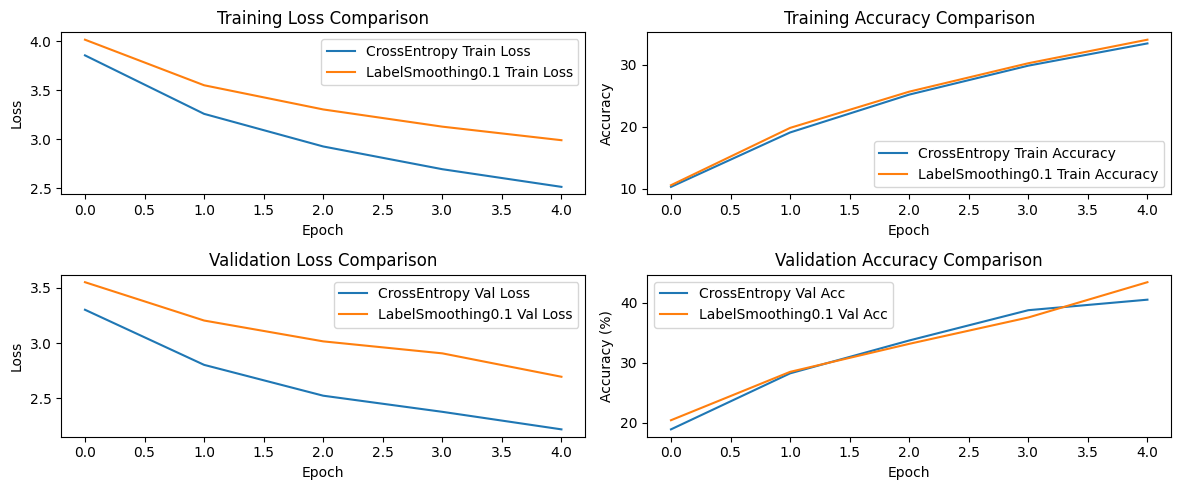

In [35]:
losses = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "LabelSmoothing0.1": nn.CrossEntropyLoss(label_smoothing=0.1)
}
results = {}
for name, loss_fn in losses.items():
    print(f"Training with {loss_fn}")
    set_seed(0)
    model = make_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = train_one(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=5)
    results[name] = history

    print("\n--- Αποτελέσματα Loss Functions ---")
    plot_training_curves(results)
